In [1]:
import numpy as np
import matplotlib.pyplot as plt
from param_calc import get_effect
import json

In [2]:
class AP():
    iru: int
    iss: int
    ism: int

    autobomb_base = 0.55
    autobomb_whiting_time = 1.417
    bamboo_base = 0.07

    def __init__(self, iru, iss, ism):
        self.iru = iru
        self.iss = iss
        self.ism = ism
        with open('parameter.json', 'r') as fp:
            self.parameters = json.load(fp)

    def __str__(self):
        return f"IRU = {self.iru}, ISM = {self.ism}, ISS = {self.iss}"
    
    def get_effect(self, category, parameter, points):
        return get_effect(self.parameters[category][parameter], points, False)
    
    def ink_recovery_time(self, param: str) -> float:
        return self.get_effect("Ink Recovery Up", param, self.iru) / 60

    def ink_recovered_per_second(self, t: float, param: str) -> float:
        return t / self.ink_recovery_time(param)
    
    def ink_consumption_main(self) -> float:
        return AP.bamboo_base * self.get_effect("Ink Saver Main", "Mid", self.ism)

    def shots_tank_level(self, f: float) -> int:    
        return np.floor(f / self.ink_consumption_main())

    def shots_full_tank(self) -> int:
        return self.shots_tank_level( 1.0)
    
    def shots_at_time(self, t: float) -> int:
        return self.shots_tank_level(1.0 + self.ink_recovered_per_second(t, "Standing"))
    
    def ink_consumption_sub(self) -> float:
        return AP.autobomb_base * self.get_effect("Ink Saver Sub", "Mid", self.iss)

    def bombs_tank_level(self, f: float) -> int:    
        return np.floor(f / self.ink_consumption_sub())

    def bombs_full_tank(self) -> int:
        return self.bombs_tank_level(1.0)
    
    def immediate_bombs(self) -> int:
        return np.floor(1.0 / self.ink_consumption_sub())
    
    def first_new_bomb(self) -> float:
        bomb_cost = self.ink_consumption_sub()
        ink_left = 1.0 - self.immediate_bombs() * bomb_cost
        return AP.autobomb_whiting_time + (bomb_cost - ink_left) * self.ink_recovery_time("In Ink")
    
    def bombs_at_time(self, t: float) -> int:
        bomb_cost = self.ink_consumption_sub()
        time_after_initial_recovery = t - self.first_new_bomb()
        time_between_throws = AP.autobomb_whiting_time + bomb_cost * self.ink_recovery_time("In Ink")
        additional_bombs = np.ceil(time_after_initial_recovery / time_between_throws)
        return self.immediate_bombs() + additional_bombs

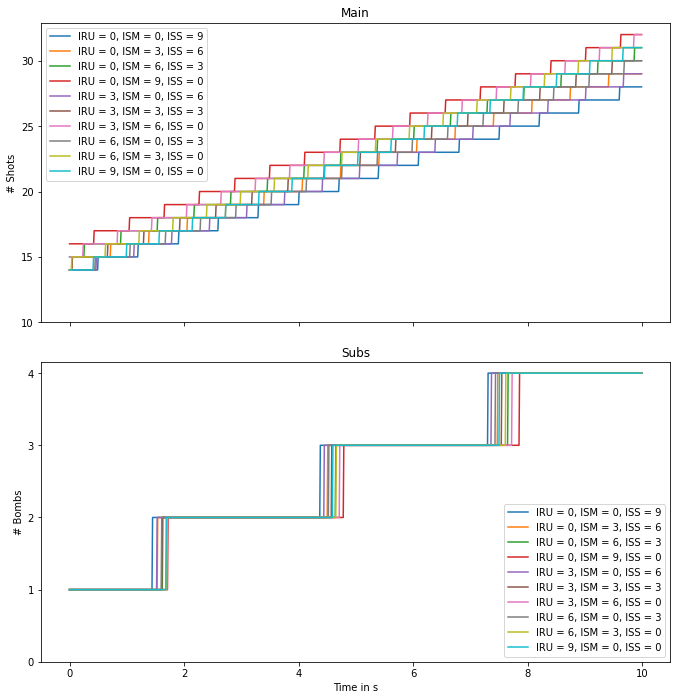

In [3]:
time_steps = np.arange(0, 10, 0.01)
max_ap = 9
fig, axs = plt.subplots(2, sharex=True)
fig.set_size_inches(10, 10)
fig.patch.set_facecolor('white')
fig.tight_layout(pad=3.0)
for iru in np.arange(0, max_ap + 1, 3):
    for ism in np.arange(0, max_ap - iru + 1, 3):
        iss = max_ap - iru - ism
        ap = AP(iru, iss, ism)
        n_shots = [ap.shots_at_time(t) for t in time_steps]
        axs[0].plot(time_steps, n_shots, label=ap)
        n_bombs = [ap.bombs_at_time(t) for t in time_steps]
        axs[1].plot(time_steps, n_bombs, label=ap)
axs[0].legend()
axs[0].set_ylim(bottom=10)
axs[0].set_ylabel("# Shots")
axs[0].set_title("Main")
axs[1].legend()
axs[1].set_ylim(bottom=0)
axs[1].set_yticks(np.arange(0, axs[1].get_ylim()[1]))
axs[1].set_xlabel("Time in s")
axs[1].set_ylabel("# Bombs")
axs[1].set_title("Subs")
fig.savefig('full.pdf')
fig.savefig('full.png', dpi=500, bbox_inches='tight', pad_inches=0)

In [4]:
def compare_bomb(ap1: AP, ap2: AP):
    print(f"Set 1: {ap1}; Set 2: {ap2}")
    immediate_diff = ap1.immediate_bombs() - ap2.immediate_bombs()
    if immediate_diff != 0:
        print(f"Set 1 gets to throw {ap1.immediate_bombs()} bombs immediately, while set 2 throws {ap2.immediate_bombs()}.")
    else:
        diff = ap1.first_new_bomb() - ap2.first_new_bomb()
        if diff != 0:
            print("Set {} throws its bomb first by {:05.4f} seconds. Set 1 takes {:05.4f} seconds, while Set 2 takes {:05.4f} seconds.".format(1 if diff < 0 else 2, abs(diff), ap1.first_new_bomb(), ap2.first_new_bomb()))

In [5]:
compare_bomb(AP(3, 3, 3), AP(6, 0, 3))
compare_bomb(AP(3, 3, 3), AP(0, 6, 3))
compare_bomb(AP(3, 3, 3), AP(0, 9, 0))

Set 1: IRU = 3, ISM = 3, ISS = 3; Set 2: IRU = 6, ISM = 3, ISS = 0
Set 1 throws its bomb first by 0.0827 seconds. Set 1 takes 1.6145 seconds, while Set 2 takes 1.6972 seconds.
Set 1: IRU = 3, ISM = 3, ISS = 3; Set 2: IRU = 0, ISM = 3, ISS = 6
Set 2 throws its bomb first by 0.0839 seconds. Set 1 takes 1.6145 seconds, while Set 2 takes 1.5306 seconds.
Set 1: IRU = 3, ISM = 3, ISS = 3; Set 2: IRU = 0, ISM = 0, ISS = 9
Set 2 throws its bomb first by 0.1699 seconds. Set 1 takes 1.6145 seconds, while Set 2 takes 1.4446 seconds.
